# 信息系数IC

## 目录
1. Alphalen是什么？
2. 编写momentum因子
3. Alphalens数据格式
4. 计算不同Quantiles收益与标准差
5. 收益曲线可视化
6. 信息系数

## 1_Alphalen是什么？

Alphalens是一个Python包，用于对阿尔法因子进行性能分析。Alpha因子表示一些给定的信息和未来的回报之间的预测关系。通过将这种关系应用于多个股票，能够产生阿尔法信号，然后从中交易。开发一个好的alpha信号是很有挑战性的，那么用Alphalens能让事情变得更简单，因为一套用于分析alpha因素的常用工具会对量化交易产生很大的影响。通过Alphalens分析你在研究中的因素，你可以花更少的时间来写和运行回测。因此，这允许更快的思想迭代，以及最终的算法，您可以对它有信心。Alphalens建立了一个严格的工作流程，将使你的策略更有活力，更不容易过度拟合。

下载方式： pip install alphalens

官方网站： http://quantopian.github.io/alphalens/index.html

## 2_编写momentum因子
读取相应数据，编制函数需要的算法，调用talib计算momentum，输出Factor数据

In [1]:
import numpy as np
from jaqs.data import DataView
from jaqs.research import SignalDigger
import warnings

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
import talib as ta
import numpy as np
import pandas as pd
from datetime import datetime

def change_time(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

In [3]:
prices = change_time(dv.get_ts('close_adj').loc[20160105:].dropna(how='all', axis=1))

In [4]:
def momentum(prices, period=60):
    return pd.DataFrame(
            {name: pd.Series(ta.ROCR(price.values, period), index=price.index)
            for name, price in prices.iteritems()})

In [5]:
alpha_mom = momentum(prices)

## 3_Alphalens数据格式

factor: MultiIndex（用stack()方法来转换）

prices: DataFrame

In [6]:
#转换成MultiIndex
factor = alpha_mom.stack()
print (factor.tail())

2017-12-22  603799.SH    0.952009
            603833.SH    1.174529
            603858.SH    0.736165
            603885.SH    1.025430
            603993.SH    0.847368
dtype: float64


In [7]:
#输入Alphalen所需要的数据格式
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
print (factor_data.head())

                             1         5        10    factor  factor_quantile
date       asset                                                             
2016-04-06 000001.SZ -0.012127  0.008396 -0.018657  0.940351                3
           000002.SZ  0.000000  0.000000  0.000000  1.000000                4
           000008.SZ  0.000922 -0.006452 -0.037788  1.003700                4
           000009.SZ  0.000675 -0.013504 -0.065496  0.961688                4
           000012.SZ -0.015084  0.000887 -0.053239  0.964897                4


## 4_计算不同Quantiles期望收益与标准差

alphalens.performance.mean_return_by_quantile()

In [8]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)
print(mean_return_by_q.head())
print(std_err_by_q.head())

                                  1         5         10
factor_quantile date                                    
1               2016-04-06  0.000450 -0.000061 -0.011166
                2016-04-07 -0.000241  0.005028 -0.010330
                2016-04-08  0.000355  0.005025 -0.012022
                2016-04-11  0.002764  0.007706 -0.003981
                2016-04-12  0.002932  0.000113 -0.010116
                                  1         5         10
factor_quantile date                                    
1               2016-04-06  0.001611  0.003794  0.004970
                2016-04-07  0.001365  0.003718  0.006356
                2016-04-08  0.001427  0.003344  0.004862
                2016-04-11  0.001571  0.004057  0.005148
                2016-04-12  0.002047  0.002551  0.003584


## 5_收益曲线可视化
1. 持有不同天数的收益曲线
2. 累积收益曲线

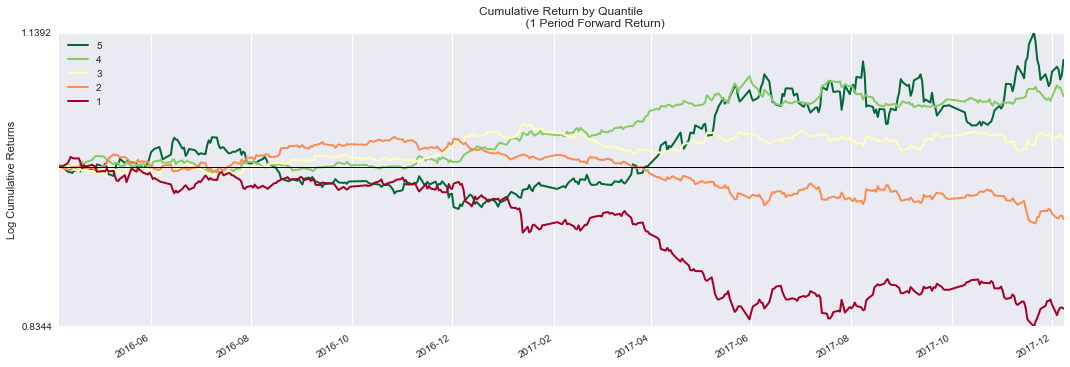

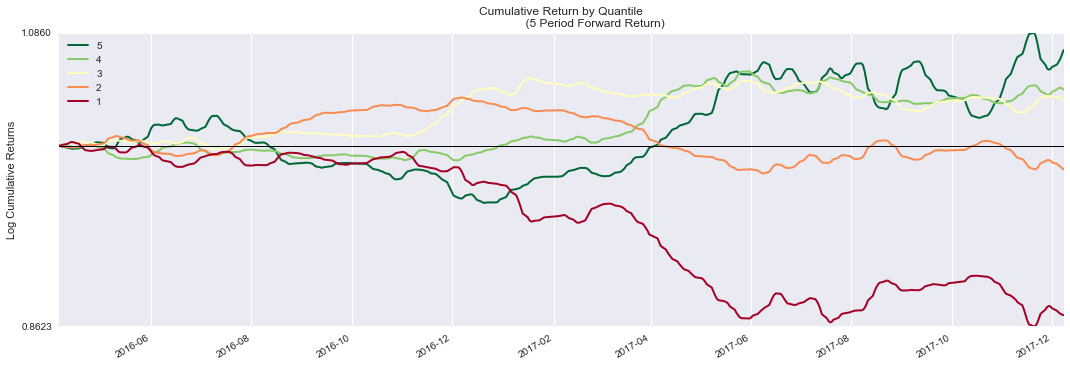

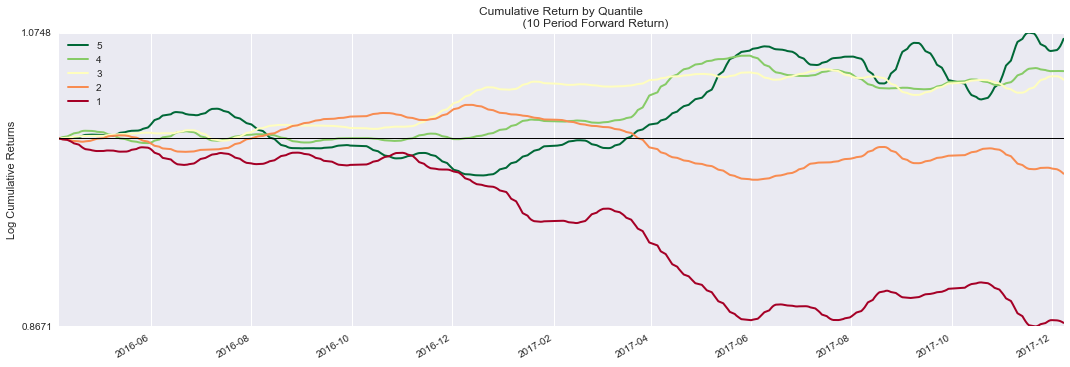

In [9]:
import matplotlib.pyplot as plt

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

## 6_信息系数IC

度量变量的预测值与实际值之间的关系的相关值。信息系数是用来评估金融分析师预测技能的一种表现方法。

系数在-1到1之间，越大表示正相关程度强。标准是mean(IC)>0.02

### spearman相关系数

## $$P_s = 1- \frac {6\sum d_i^2}{n(n^2-1)}$$

其中d为秩次差。

因此IC值是代表因子排序与收益排序的相关性。

### 什么是秩次差？
A = [1,3,5,7,9]
B = [3,2,4,5,1]

A的排序是1,2,3,4,5

B的排序是3,2,4,5,1

d为排序相减

## $$d^2 = 4,0,1,1,16$$

## $$P_s = 1-\frac{6*22}{5(25-1)} = -0.1$$

IC值例子


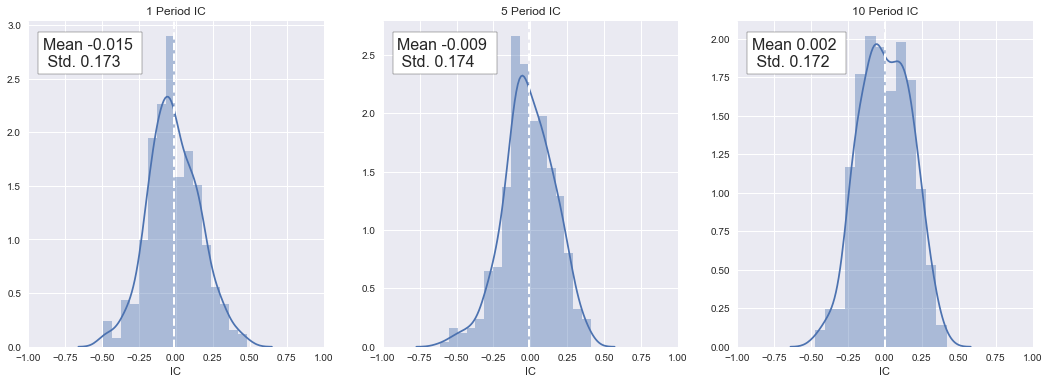

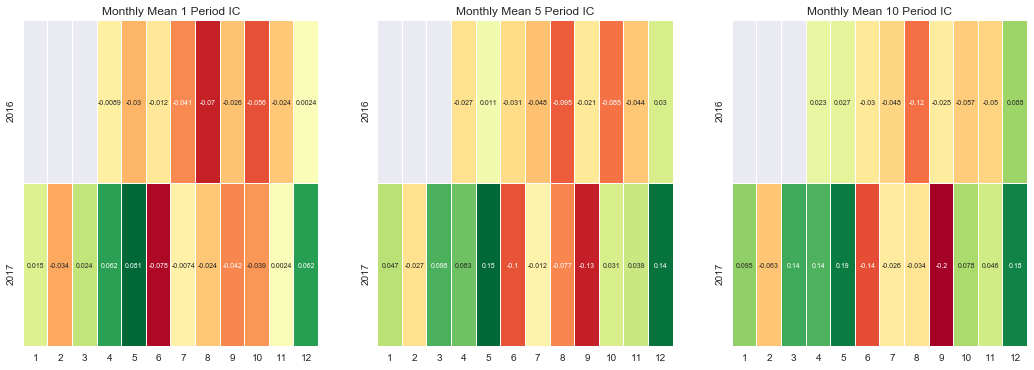

In [10]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
# print (ic)
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
# print mean_monthly_ic.mean()
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()

In [11]:
factor_returns = alphalens.performance.factor_returns(factor_data)

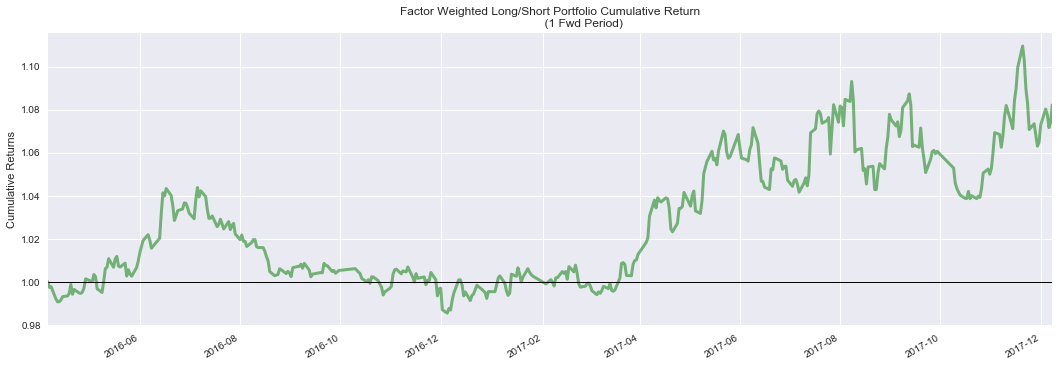

In [12]:
alphalens.plotting.plot_cumulative_returns(factor_returns[1])
plt.show()

## 作业
试用alphalens不同的功能。